<a href="https://colab.research.google.com/github/BrajanNieto/MPPT_Algorithms/blob/main/IA_Fundamentals_Evaluation_MPPT_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IA Fundamentals - MPPT Algorithms**

---



*   This script focuses on evaluating the efficiency of Maximum Power Point Tracking (MPPT) algorithms in photovoltaic (solar) systems. It conducts a comparative analysis of three specific algorithms: Perturb and Observe (P&O), Genetic Algorithms (GA), and Artificial Neural Networks (ANN).

**Professor:**  
Mg. Machaca Vicente Arceda  
[vicente.machaca.a@gmail.com](mailto:vicente.machaca.a@gmail.com)

**Authors:**  
Nevado Talledo, Jose E.  
[jose.nevado@utec.edu.pe](mailto:jose.nevado@utec.edu.pe)

Nieto Espinoza, Brajan E.  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Peña la Torre, Walter J.

[walter.pena.l@utec.edu.pe](mailto:walter.pena.l@utec.edu.pe)


<img src="https://pregrado.utec.edu.pe/sites/default/files/logo-utec-h_0_0.svg" width="190" alt="Logo UTEC" loading="lazy" typeof="foaf:Image">

---

In [1]:
# Import standard libraries for numerical computations and data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import lambertw
import math
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor


# **1 Problem and Fitness Formulation**
In this section, the theoretical behavior of a **single-diode solar panel** is modeled. The following components are addressed:

1. **Definition of Profiles**:
   - **Temperature profile**: Variation of panel temperature over time.
   - **Irradiance profile**: Variation of solar irradiance over time.

2. **Modeling the Theoretical Behavior**:
   - Using the single-diode model equations to describe the relationship between current, voltage, and power under different conditions.

3. **Maximum Power Behavior**:
   - The calculation and visualization of the **maximum power output** (\(P_{max}\)) as a function of time, based on the temperature and irradiance profiles.

### Objective:
This formulation lays the foundation for analyzing the performance of the solar panel in dynamic environmental conditions, providing insights into its efficiency and energy output over time.


## 1.1 Irradiance and Temperature Profile
Defines functions that models the variation of irradiance and temperature over time in a photovoltaic system. The function uses conditional statements to describe changes in irradiance based on specified time intervals.

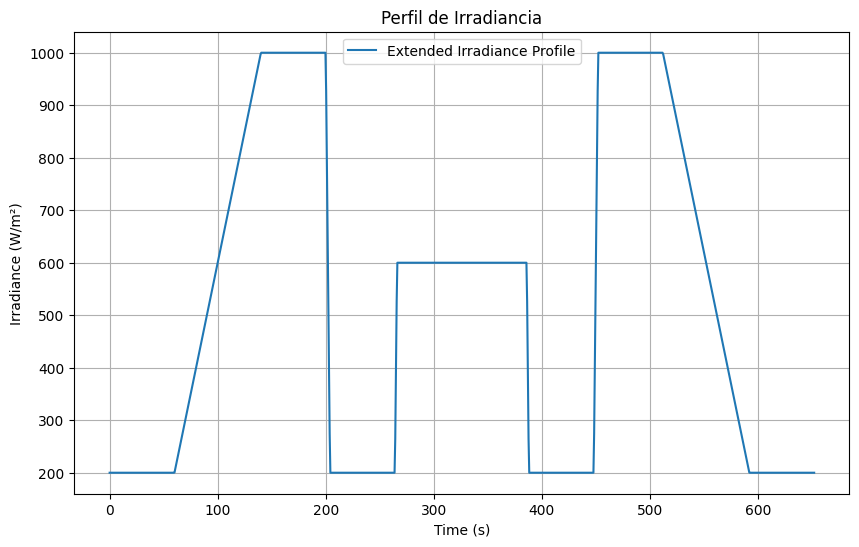

In [2]:
def irradiance_profile(time):
    """
    Defines how irradiance varies over time.
    """
    if time <= 60:
        return 200
    elif 60 < time <= 140:
        return 200 + 10 * (time - 60)
    elif 140 < time <= 200:
        return 1000
    elif 200 < time <= 204:
        return 1000 - 200 * (time - 200)
    elif 204 < time <= 264:
        return 200
    elif 264 < time <= 266:
        return 200 + 200 * (time - 264)
    elif 266 < time <= 386:
        return 600
    elif 386 < time <= 388:
        return 600 - 200 * (time - 386)
    elif 388 < time <= 448:
        return 200
    elif 448 < time <= 452:
        return 200 + 200* (time - 448)
    elif 452 < time <= 512:
        return 1000
    elif 512 < time <= 592:
        return 1000 - 10 * (time - 512)
    elif 592 < time <= 652:
        return 200
    else:
        return 200


time_extended = np.linspace(0, 652, 1000)
irradiance_extended = [irradiance_profile(t) for t in time_extended]

# Plot the extended irradiance profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, irradiance_extended, label="Extended Irradiance Profile")
plt.title("Perfil de Irradiancia")
plt.xlabel("Time (s)")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()


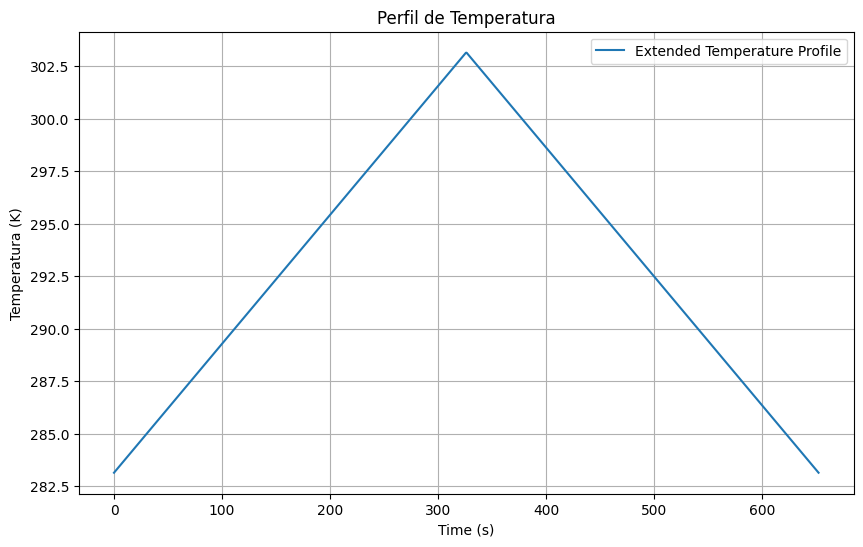

In [9]:
def temperature_profile(time):
    """
    Defines how temperature varies over time.
    """
    if time <= 326:
        # Temperature increases from 25°C (298.15 K) to 35°C (308.15 K) over 326 seconds
        return 283.15 + (time / 326) * 20
    elif 326 < time <= 652:
        # Temperature decreases from 35°C (308.15 K) to 25°C (298.15 K) over 326 seconds
        return 303.15 - ((time - 326) / 326) * 20
    else:
        return 298.15


temperature_extended = [temperature_profile(t) for t in time_extended]

# Plot the temperature profile over time.
plt.figure(figsize=(10, 6))
plt.plot(time_extended, temperature_extended, label="Extended Temperature Profile")
plt.title("Perfil de Temperatura")
plt.xlabel("Time (s)")
plt.ylabel("Temperatura (K)")
plt.grid()
plt.legend()
plt.show()


## 1.2 Photocurrent (Iph)

Calculate_Iph function to compute the photocurrent (Iph) as a function of time, temperature, and irradiance. The calculation uses temperature and irradiance profiles, alongside key reference parameters. The script then plots the time-dependent behavior of Iph.

The equation used to calculate the photocurrent \(I_{ph}\) is:

$I_{ph} = \left(I_{sc\_ref} + \alpha_{Isc} \cdot (T - T_{ref})\right) \cdot \frac{G}{G_{ref}}$

Where:

- $I_{sc\_ref}$: Short-circuit current under standard conditions (A).
- $\alpha_{Isc}$: Temperature coefficient for $I_{sc}$ (in A/K).
- $T$: Temperature in Kelvin as a function of time.
- $T_{ref}$: Reference temperature in Kelvin.
- $G$: Solar irradiance (in W/m²) as a function of time.
- $G_{ref}$: Reference solar irradiance (in W/m²).


In [13]:
# Solar panel parameters
I_sc_ref = 8.5        # Short-circuit current under standard conditions (A)
alpha_Isc = 0.0005    # Temperature coefficient of I_sc (A/K)
T_ref = 298.15        # Reference temperature (25°C in Kelvin)
G_ref = 1000          # Reference solar irradiance (W/m²)

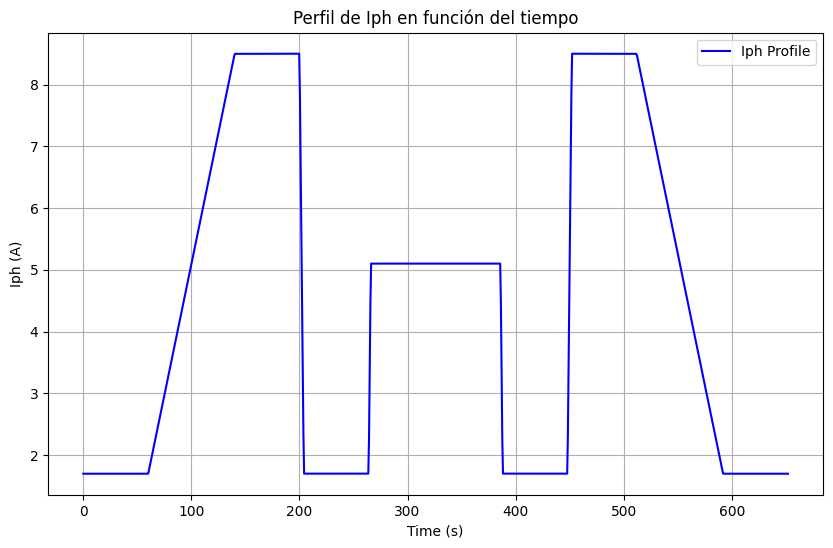

In [17]:
def calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref):
    """
    Calculates the photocurrent (Iph) as a function of time.

    Parameters:
        time (float): Time at which Iph is calculated.
        I_sc_ref (float): Short-circuit current under standard conditions (A).
        alpha_Isc (float): Temperature coefficient of Isc (A/K).
        T_ref (float): Reference temperature in Kelvin.
        G_ref (float): Reference solar irradiance (W/m^2).

    Returns:
        float: Value of Iph at the given time.
    """
    # Get temperature (T) and irradiance (G) values from their respective profiles
    T = temperature_profile(time)  # Temperature in Kelvin
    G = irradiance_profile(time)   # Irradiance in W/m^2

    # Calculate Iph using the formula:
    Iph = (I_sc_ref + alpha_Isc * (T - T_ref)) * (G / G_ref)
    return Iph


Iph_extended = [calculate_Iph(t, I_sc_ref, alpha_Isc, T_ref, G_ref) for t in time_extended]

# Plot the Iph profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, Iph_extended, label="Iph Profile", color='blue')
plt.title("Perfil de Iph en función del tiempo")
plt.xlabel("Time (s)")
plt.ylabel("Iph (A)")
plt.grid()
plt.legend()
plt.show()

## 1.3 Reverse Saturation Current ($ I_0 $)

La corriente de saturación inversa del diodo, $ I_0 $, se calcula con la siguiente fórmula:

$
I_0 = I_{sc\_ref} \cdot \left( \frac{T}{T_{ref}} \right)^3 \cdot e^{-\frac{E_g \cdot q}{k \cdot T}}
$

Where:

- $I_{sc_{ref\_cell}}$: Short-circuit current per cell under reference conditions.
- $V_{oc_{ref\_cell}}$: Open-circuit voltage per cell under reference conditions.
- $n$: Ideality factor.
- $T_{ref}$: Reference temperature (K).
- $T$: Temperature as a function of time (K).
- $E_{g}$: Energy bandgap of the semiconductor (eV).
- $k$: Boltzmann constant (\(1.38 \times 10^{-23} \, \text{J/K}\)).
- $q$: Electron charge (\(1.6 \times 10^{-19} \, \text{C}\)).
- $I_0$: Reverse saturation current at a given time.


In [15]:
# Physical constants
k = 1.380649e-23     # Boltzmann constant (J/K)
q = 1.602176634e-19  # Electron charge (C)

# Solar panel parameters
V_oc_ref = 22.0       # Open-circuit voltage under standard conditions (V)
n = 1.3               # Diode ideality factor
E_g = 1.1             # Bandgap energy (eV)
R_s = 0.1             # Series resistance (Ω)
R_sh = 1000.0         # Shunt resistance (Ω)

# Determine the number of cells in series
V_oc_cell = 0.611        # Open-circuit voltage per cell (V)
N_s = int(V_oc_ref / V_oc_cell)  # Number of cells in series
#print(f"Number of cells in series: {N_s}")

# Parameters per cell
I_sc_ref_cell = I_sc_ref            # Short-circuit current per cell (A)
V_oc_ref_cell = V_oc_ref / N_s      # Open-circuit voltage per cell (V)
R_s_cell = R_s / N_s                # Series resistance per cell (Ω)
R_sh_cell = R_sh * N_s              # Shunt resistance per cell (Ω)

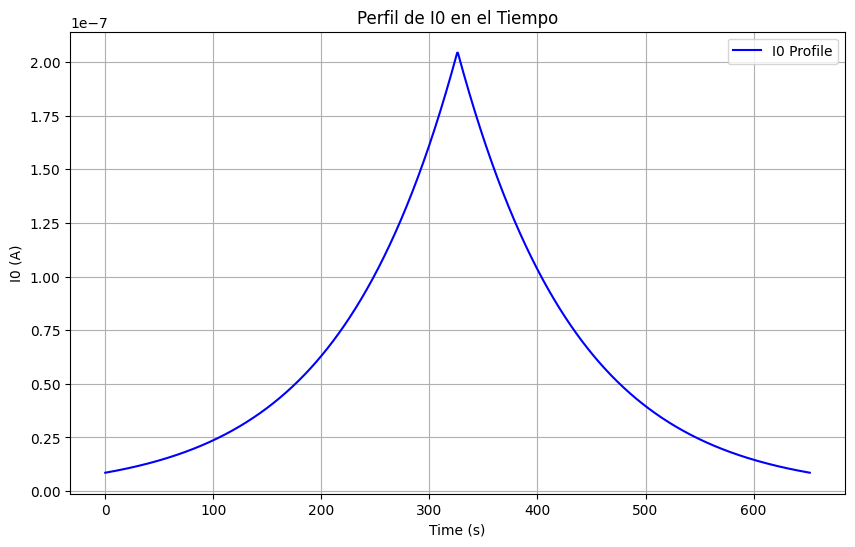

In [19]:
def calculate_I0(time, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q):
    """
    Calculates the reverse saturation current (I0) of a solar cell as a function of time.

    Parameters:
    - time: Current time (in seconds).
    - I_sc_ref_cell: Short-circuit current per cell under reference conditions (A).
    - V_oc_ref_cell: Open-circuit voltage per cell under reference conditions (V).
    - n: Diode ideality factor.
    - T_ref: Reference temperature (K).
    - E_g: Bandgap energy (eV).
    - k: Boltzmann constant (J/K).
    - q: Electron charge (C).

    Returns:
    - I0: Reverse saturation current at the given time (A).
    """
    T = temperature_profile(time)  # Temperature at the given time (K)
    E_g_J = E_g * q                # Bandgap energy in Joules
    V_t_ref = k * T_ref / q        # Thermal voltage under reference conditions (V)
    exponent_ref = q * V_oc_ref_cell / (n * k * T_ref)  # Exponent for reference conditions

    # Calculate I0_ref, the reverse saturation current under reference conditions
    if exponent_ref > 100:
        I0_ref = I_sc_ref_cell * math.exp(-exponent_ref)
    else:
        I0_ref = I_sc_ref_cell / (math.exp(exponent_ref) - 1)

    # Temperature-dependent terms
    delta_T_inv = (1 / T) - (1 / T_ref)  # Inverse temperature difference
    exponent = -E_g_J / k * delta_T_inv  # Temperature exponent

    # Calculate I0 as a function of time
    I0 = I0_ref * (T / T_ref)**3 * math.exp(exponent)
    return I0

# Plot the I0 profile over time
I0_extended = [calculate_I0(t, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q) for t in time_extended]
plt.figure(figsize=(10, 6))
plt.plot(time_extended, I0_extended, label="I0 Profile", color='blue')
plt.title("Perfil de I0 en el Tiempo")
plt.xlabel("Time (s)")
plt.ylabel("I0 (A)")
plt.grid()
plt.legend()


##1.4 Single-Diode model


The single-diode model for a solar panel is described by the following equation:

$I = I_{ph} - I_0 \cdot \left( e^{\frac{q \cdot (V + I \cdot R_s)}{n \cdot k \cdot T}} - 1 \right) - \frac{V + I \cdot R_s}{R_{sh}}$

### Donde:
- $I$: Output current of the solar panel (A).
- $I_{ph}$: Photocurrent generated by the incident light (A).
- $I_0$: Reverse saturation current of the diode (A).
- $q$: Electron charge (\(1.602 \times 10^{-19} \, C\)).
- $V$: Voltage across the terminals of the solar panel (V).
- $R_s$: Series resistance of the solar panel (\(\Omega\)).
- $R_{sh}$: Parallel (shunt) resistance of the solar panel (\(\Omega\)).
- $n$: Ideality factor of the diode (typically between 1 and 2).
- $k$: Boltzmann constant (\(1.381 \times 10^{-23} \, J/K\)).
- $T$: Absolute temperature of the panel (K).

In [22]:
def current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q):
    """
    Calculates the current of a single-diode solar cell model given the voltage and time.

    Parameters:
    - V: Voltage across the solar cell (V).
    - time: Current time (in seconds).
    - I_sc_ref: Reference short-circuit current under standard conditions (A).
    - alpha_Isc: Temperature coefficient of the short-circuit current (A/K).
    - V_oc_ref: Reference open-circuit voltage (V).
    - n: Diode ideality factor.
    - T_ref: Reference temperature (K).
    - G_ref: Reference solar irradiance (W/m²).
    - E_g: Bandgap energy (eV).
    - R_s: Series resistance (Ω).
    - R_sh: Shunt resistance (Ω).
    - k: Boltzmann constant (J/K).
    - q: Electron charge (C).

    Returns:
    - Current (I) through the solar cell (A).
    """
    # Calculate the photo-generated current (I_ph)
    I_ph = calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref)
    # Calculate the reverse saturation current (I_0)
    I_0 = calculate_I0(time, I_sc_ref, V_oc_ref, n, T_ref, E_g, k, q)
    # Get the temperature at the given time
    T = temperature_profile(time)
    # Calculate the thermal voltage
    V_t = k * T / q

    # Define the implicit diode equation to solve
    def diode_equation(I):
        exponent = (V + I * R_s) / (n * V_t)
        # Control the exponent to avoid OverflowError
        if exponent > 700:
            exp_term = np.exp(700)  # Limit the exponential term to prevent overflow
        else:
            exp_term = np.exp(exponent)
        return I_ph - I_0 * (exp_term - 1) - (V + I * R_s) / R_sh - I

    # Use fsolve to solve the diode equation
    I_initial_guess = I_ph  # Initial guess for the solution
    I_solution, info, ier, mesg = fsolve(diode_equation, I_initial_guess, full_output=True)
    # Check if the solver converged
    if ier != 1:
        print(f"Solution not found for V={V}, time={time}: {mesg}")
        I_solution = [np.nan]  # Assign NaN if the solution does not converge
    return I_solution[0]


## 1.5 Calculation of IV and PV Profiles for Different Times

This section focuses on the calculation of the **IV (current-voltage)** and **PV (power-voltage)** profiles for a solar panel at different time intervals. These profiles aid in the **visual inspection** of the panel's performance under varying conditions.

### Key Objectives:
1. Compute the **IV profile**: Relationship between current (\(I\)) and voltage (\(V\)).
2. Compute the **PV profile**: Relationship between power (\(P\)) and voltage (\(V\)).
3. Enable visual analysis of how environmental factors, such as temperature and irradiance, affect the panel's performance.

### Visual Inspection:
- The **IV curve** provides insight into the maximum current and voltage the panel can deliver.
- The **PV curve** highlights the maximum power point (MPP), where the panel operates most efficiently.

Graphs generated from these profiles allow for the assessment of:
- The **impact of changing environmental conditions** over time.
- The **efficiency and performance** of the solar panel in real-time scenarios.

Solution not found for V=23.149549549549548, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.175975975975973, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.202402402402402, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.228828828828828, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.255255255255253, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.28168168168168, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.3

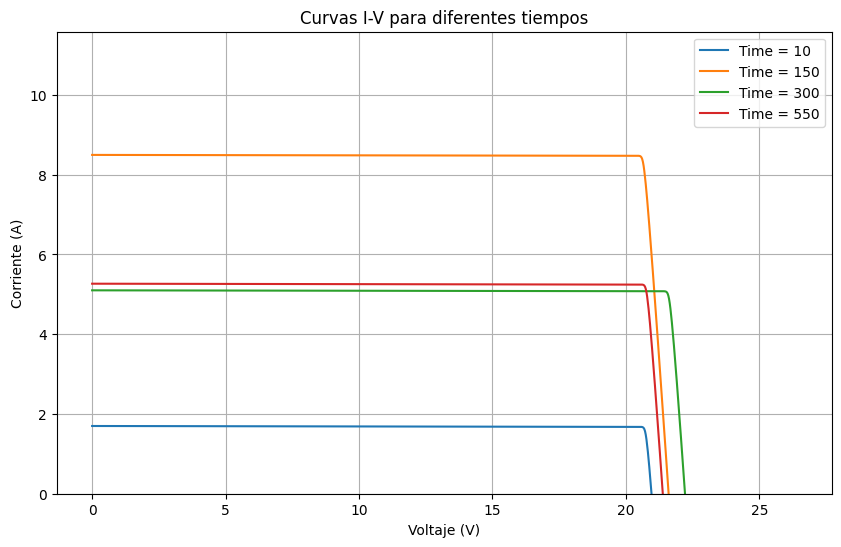

In [23]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Plot the I-V curves for each specified time
plt.figure(figsize=(10, 6))
for time in times:
    I_values = []  # List to store current values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    # Plot the I-V curve for the current time
    plt.plot(V_values, I_values, label=f'Time = {time}')

# Limit the Y-axis to non-negative values
plt.ylim(0, None)

# Customize labels and legend
plt.title('Curvas I-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (A)')
plt.legend()
plt.grid(True)
plt.show()

Solution not found for V=23.149549549549548, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.175975975975973, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.202402402402402, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.228828828828828, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.255255255255253, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.28168168168168, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.3

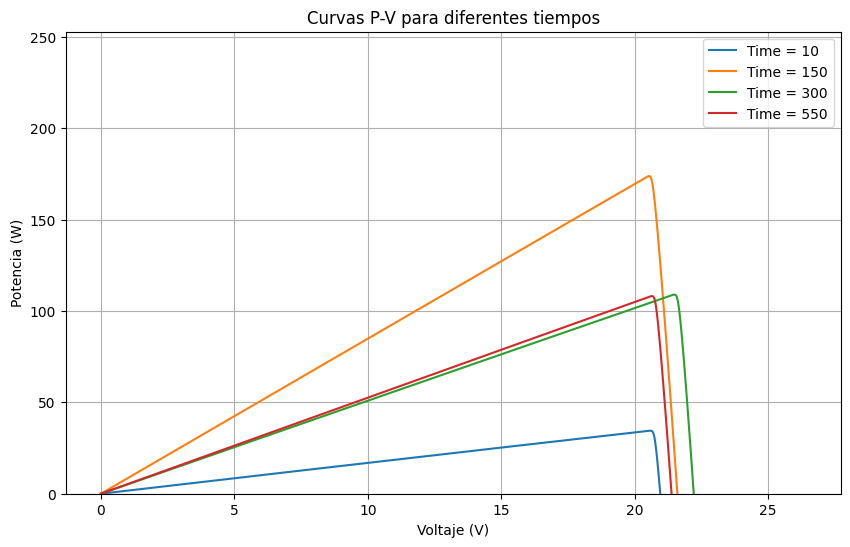

In [24]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Plot the P-V curves for each specified time
plt.figure(figsize=(10, 6))
for time in times:
    P_values = []  # List to store power values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Calculate power as the product of voltage and current
        P_values.append(P)
    # Plot the P-V curve for the current time
    plt.plot(V_values, P_values, label=f'Time = {time}')

# Limit the Y-axis to non-negative values
plt.ylim(0, None)

# Customize labels and legend
plt.title('Curvas P-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W)')
plt.legend()
plt.grid(True)
plt.show()

Solution not found for V=23.149549549549548, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.175975975975973, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.202402402402402, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.228828828828828, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.255255255255253, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.28168168168168, time=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.3

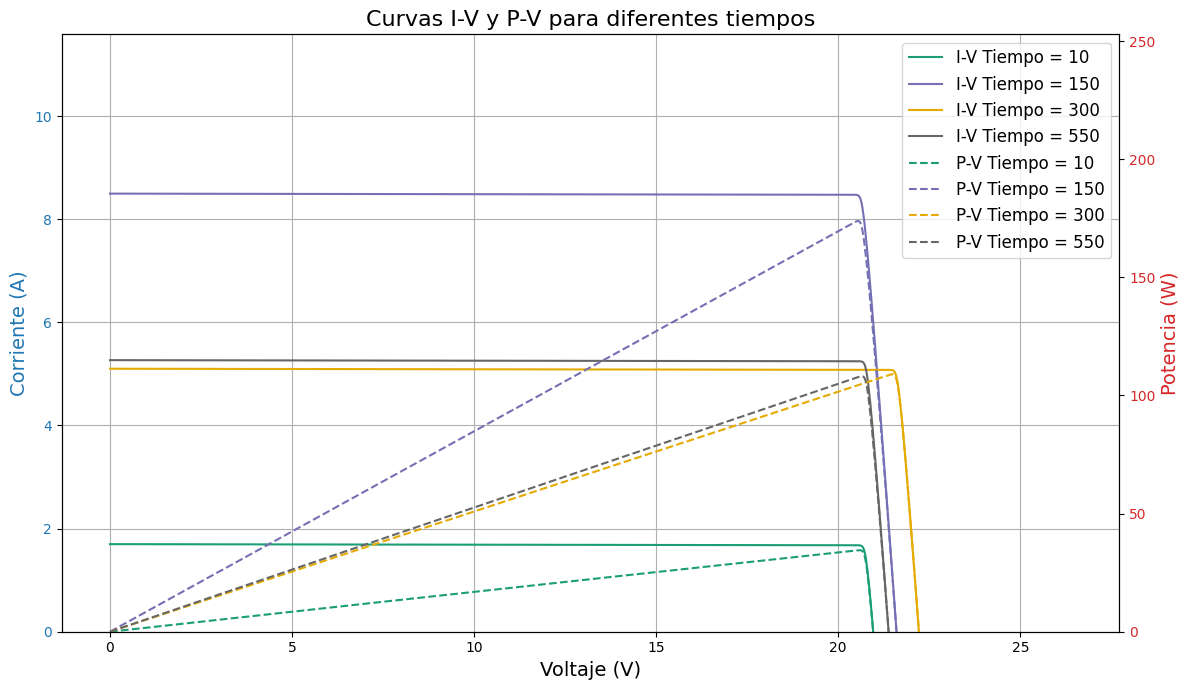

In [27]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Colors for different times
colors = plt.cm.Dark2(np.linspace(0, 1, len(times)))

# Plot the I-V curves for each time on the main axis
for idx, time in enumerate(times):
    I_values = []  # List to store current values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    ax1.plot(V_values, I_values, label=f'I-V Tiempo = {time}', color=colors[idx], linestyle='-')

# Configure the primary Y-axis (Current)
ax1.set_xlabel('Voltaje (V)', fontsize=14)
ax1.set_ylabel('Corriente (A)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, None)  # Limit to non-negative values

# Create the secondary Y-axis for Power
ax2 = ax1.twinx()

# Plot the P-V curves for each time on the secondary axis
for idx, time in enumerate(times):
    P_values = []  # List to store power values
    for V in V_values:
        # Calculate power as the product of voltage and current
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I
        P_values.append(P)
    ax2.plot(V_values, P_values, label=f'P-V Tiempo = {time}', color=colors[idx], linestyle='--')

# Configure the secondary Y-axis (Power)
ax2.set_ylabel('Potencia (W)', fontsize=14, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, None)  # Limit to non-negative values

# Title and legends
plt.title('Curvas I-V y P-V para diferentes tiempos', fontsize=16)

# Manage legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

# Add a grid
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


## 1.6 Calculation of Maximum Power as a Function of Time

Given the functions that model the theoretical IV curve based on the solar panel parameters, along with the irradiance and temperature profiles over time, this section focuses on calculating the **maximum power curve** as a function of time.

### Key Steps:
1. Utilize the theoretical IV curve equations to compute power (\(P = V \cdot I\)) for varying voltage and current values.
2. Incorporate time-dependent profiles of:
   - **Irradiance** (t).
   - **Temperature** (t).
3. Identify the **Maximum Power Point (MPP)** at each time interval, where the panel operates with maximum efficiency.

In [30]:
# Time range (in seconds)
time_start = 1  # Start time
time_end = 652  # End time
time_steps = np.arange(time_start, time_end + 1)  # Include time_end in the range


Processing times:   1%|          | 8/652 [00:00<00:18, 35.74it/s]

Solution not found for V=26.4, time=3: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=5: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=9: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=11: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Processing times:   2%|▏         | 16/652 [00:00<00:19, 33.36it/s]

Solution not found for V=26.4, time=12: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=13: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=16: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=17: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=18: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Processing times:   4%|▍         | 29/652 [00:00<00:17, 36.42it/s]

Solution not found for V=26.4, time=21: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=23: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Processing times:  32%|███▏      | 210/652 [00:07<00:13, 32.96it/s]

Solution not found for V=22.933333333333334, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=203: Th

Processing times:  34%|███▎      | 219/652 [00:07<00:12, 35.33it/s]

Solution not found for V=25.6, time=212: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=212: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=212: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=212: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=213: The iteration i

Processing times:  35%|███▌      | 231/652 [00:08<00:12, 34.30it/s]

Solution not found for V=23.2, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=221: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=221: The iteration is

Processing times:  37%|███▋      | 243/652 [00:08<00:12, 33.63it/s]

Solution not found for V=23.2, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=232: The iteration is

Processing times:  38%|███▊      | 251/652 [00:08<00:11, 33.60it/s]

Solution not found for V=23.466666666666665, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=244: Th

Processing times:  40%|███▉      | 260/652 [00:08<00:11, 34.87it/s]

Solution not found for V=23.466666666666665, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=252: Th

Processing times:  41%|████      | 268/652 [00:09<00:11, 33.43it/s]

Solution not found for V=23.466666666666665, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=261: Th

Processing times:  42%|████▏     | 276/652 [00:09<00:11, 31.93it/s]

Solution not found for V=23.466666666666665, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=270: Th

Processing times:  44%|████▎     | 284/652 [00:09<00:10, 34.62it/s]

Solution not found for V=23.466666666666665, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=280: Th

Processing times:  45%|████▍     | 292/652 [00:09<00:11, 32.02it/s]


Solution not found for V=25.866666666666667, time=288: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=288: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=288: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=289: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=289: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=289: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=289: The iteration 

Processing times:  46%|████▌     | 300/652 [00:10<00:10, 34.76it/s]

Solution not found for V=23.466666666666665, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=296: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=296: Th

Processing times:  47%|████▋     | 308/652 [00:10<00:11, 31.11it/s]

Solution not found for V=23.2, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=303: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=303: The iteration is

Processing times:  48%|████▊     | 316/652 [00:10<00:10, 32.39it/s]


Solution not found for V=26.133333333333333, time=310: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=310: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=311: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=311: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=311: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=311: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=311: The iteration 

Processing times:  50%|████▉     | 324/652 [00:10<00:10, 32.45it/s]


Solution not found for V=24.8, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=320: The iteration 

Processing times:  51%|█████     | 332/652 [00:11<00:09, 34.09it/s]

Solution not found for V=24.266666666666666, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=328: Th

Processing times:  53%|█████▎    | 344/652 [00:11<00:09, 32.88it/s]

Solution not found for V=23.733333333333334, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=336: Th

Processing times:  54%|█████▍    | 352/652 [00:11<00:09, 32.29it/s]

Solution not found for V=23.2, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=345: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=345: The iteration is

Processing times:  55%|█████▌    | 360/652 [00:11<00:08, 33.04it/s]

Solution not found for V=23.2, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=353: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=353: The iteration is

Processing times:  56%|█████▌    | 364/652 [00:12<00:08, 33.64it/s]

Solution not found for V=23.2, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=361: The iteration is

Processing times:  57%|█████▋    | 372/652 [00:12<00:09, 30.61it/s]

Solution not found for V=26.133333333333333, time=367: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=367: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=368: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=368: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=368: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=368: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=368: The iteration i

Processing times:  58%|█████▊    | 380/652 [00:12<00:08, 31.36it/s]


Solution not found for V=24.8, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=375: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=375: The iteration 

Processing times:  60%|█████▉    | 388/652 [00:12<00:08, 32.60it/s]

Solution not found for V=23.2, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=385: The iteration is

Processing times:  61%|██████    | 396/652 [00:13<00:07, 32.39it/s]

Solution not found for V=23.466666666666665, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=392: Th

Processing times:  62%|██████▏   | 404/652 [00:13<00:07, 32.99it/s]

Solution not found for V=25.066666666666666, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=399: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=400: T

Processing times:  63%|██████▎   | 412/652 [00:13<00:07, 32.16it/s]

Solution not found for V=25.333333333333332, time=406: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=406: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=406: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=406: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=406: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=407: T

Processing times:  64%|██████▍   | 420/652 [00:13<00:06, 33.56it/s]

Solution not found for V=23.2, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=413: The iteration is

Processing times:  66%|██████▌   | 428/652 [00:14<00:06, 32.83it/s]


Solution not found for V=24.8, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=423: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=423: The iteration 

Processing times:  67%|██████▋   | 436/652 [00:14<00:06, 32.52it/s]


Solution not found for V=25.333333333333332, time=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.2, time=432: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=432: The iteration 

Processing times:  68%|██████▊   | 444/652 [00:14<00:06, 31.09it/s]


Solution not found for V=24.8, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.066666666666666, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.333333333333332, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.6, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=25.866666666666667, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.133333333333333, time=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=437: The iteration 

Processing times:  69%|██████▉   | 452/652 [00:14<00:06, 31.60it/s]

Solution not found for V=23.2, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.466666666666665, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=23.733333333333334, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.0, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.266666666666666, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.53333333333333, time=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=24.8, time=445: The iteration is

Processing times:  97%|█████████▋| 634/652 [00:22<00:00, 32.14it/s]

Solution not found for V=26.4, time=629: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=631: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=634: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=635: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=636: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Processing times:  98%|█████████▊| 642/652 [00:22<00:00, 31.83it/s]


Solution not found for V=26.4, time=639: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=640: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=641: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=643: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Processing times: 100%|██████████| 652/652 [00:22<00:00, 28.54it/s]

Solution not found for V=26.4, time=647: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solution not found for V=26.4, time=652: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


   Time (s)   Pmax (W)
0         1  34.419236
1         2  34.423234
2         3  34.426758
3         4  34.429868
4         5  34.432614


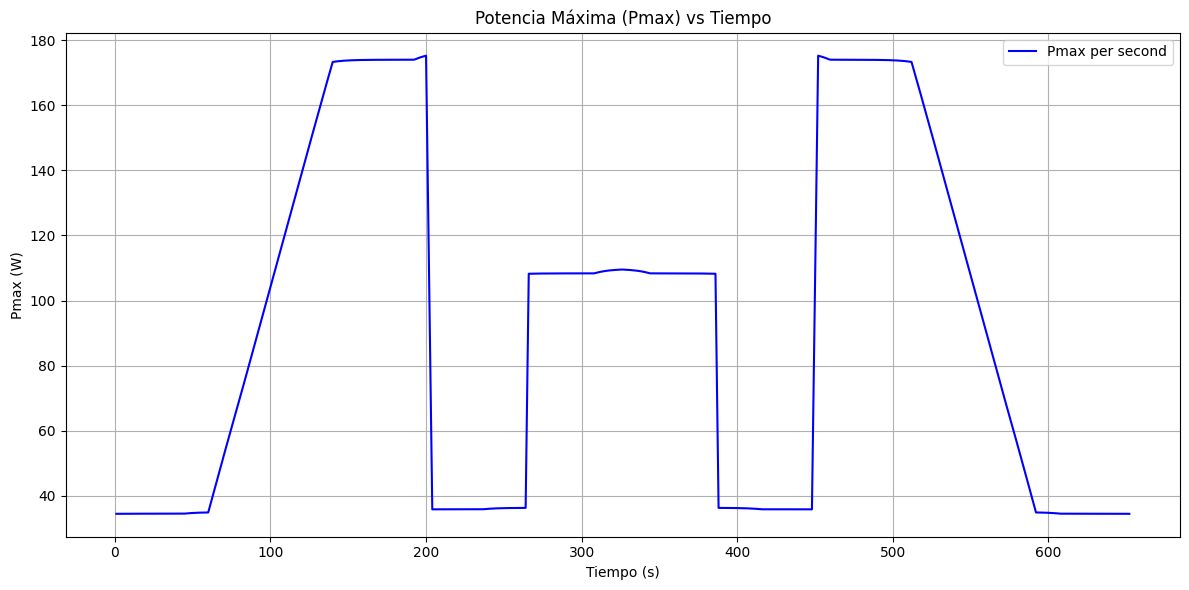

In [32]:
# List to store Pmax and corresponding times
pmax_list = []
time_list = []

# Maximum voltage multiplier for each time
V_max_multiplier = 1.2  # Multiplier for V_oc_ref

# Number of voltage points (adjust for required precision)
V_points = 100

# Iterate over each second in the time range
for current_time in tqdm(time_steps, desc="Processing times"):
    # Define the voltage range for the current time
    V_oc_current = V_oc_ref  # Assuming V_oc_ref is constant; adjust if variable
    V_max = V_max_multiplier * V_oc_current
    V_range = np.linspace(0, V_max, V_points)

    # Lists to store V, I, and P for the current time
    I_values = []
    P_values = []

    # Iterate over each voltage
    for V in V_range:
        # Calculate current using the single-diode model
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
        if np.isnan(I):
            P = 0  # Assign 0 power if the current was not found
        else:
            P = V * I  # Calculate power as the product of voltage and current
        I_values.append(I)
        P_values.append(P)

    # Find Pmax and its corresponding index
    P_values = np.array(P_values)
    if np.all(np.isnan(P_values)):
        P_max = np.nan
    else:
        P_max = np.nanmax(P_values)  # Use np.nanmax to ignore NaNs

    # Store the results
    pmax_list.append(P_max)
    time_list.append(current_time)

# Create a DataFrame with the results
df_pmax = pd.DataFrame({
    'Time (s)': time_list,
    'Pmax (W)': pmax_list
})

# Display the first few rows of the DataFrame
print(df_pmax.head())

# Save the results to a CSV file (optional)
# df_pmax.to_csv('pmax_vs_time.csv', index=False)

# Plot Pmax vs Time
plt.figure(figsize=(12, 6))
plt.plot(df_pmax['Time (s)'], df_pmax['Pmax (W)'], color='blue', label='Pmax per second')
plt.title('Potencia Máxima (Pmax) vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax (W)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     Time (s)   Pmax (W)  Irradiance  Irradiance/Pmax Ratio
0           1  34.419236         200               5.810704
1           2  34.423234         200               5.810029
2           3  34.426758         200               5.809435
3           4  34.429868         200               5.808910
4           5  34.432614         200               5.808447
..        ...        ...         ...                    ...
647       648  34.429868         200               5.808910
648       649  34.426758         200               5.809435
649       650  34.423234         200               5.810029
650       651  34.419236         200               5.810704
651       652  34.414701         200               5.811470

[652 rows x 4 columns]


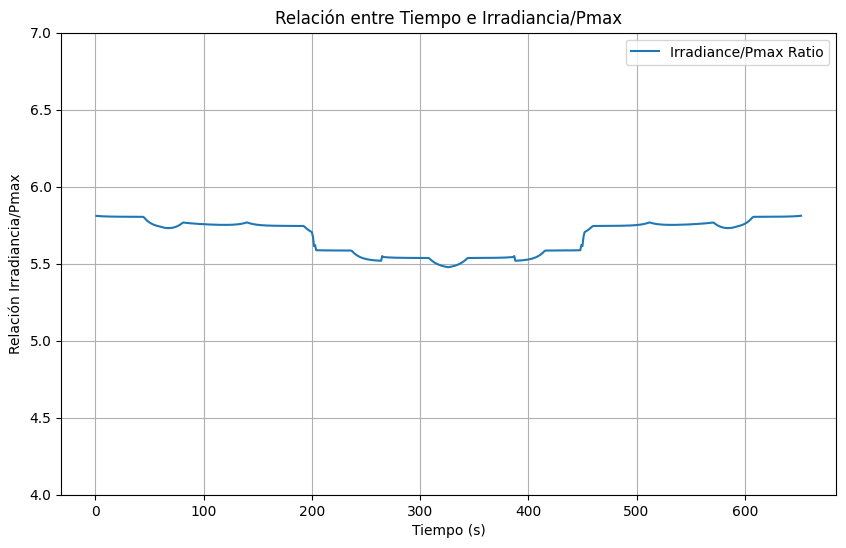

In [37]:
# Add a column for irradiance using the function
df_pmax['Irradiance'] = df_pmax['Time (s)'].apply(irradiance_profile)

# Add a column for the ratio between irradiance and Pmax
df_pmax['Irradiance/Pmax Ratio'] = df_pmax['Irradiance'] / df_pmax['Pmax (W)']

# Display the resulting DataFrame
print(df_pmax)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_pmax['Time (s)'], df_pmax['Irradiance/Pmax Ratio'], linestyle='-', label='Irradiance/Pmax Ratio')
plt.title('Relación entre Tiempo e Irradiancia/Pmax')
plt.xlabel('Tiempo (s)')
plt.ylabel('Relación Irradiancia/Pmax')
plt.ylim(4, 7)  # Scale the Y-axis between 5 and 7
plt.grid()
plt.legend()
plt.show()

# **2. Algorithms Implementation  P&O, GA and ANN**

In this section, algorithms for **Maximum Power Point Tracking (MPPT)** are developed based on the behavior of the solar panel modeled in the previous section. The implementation focuses on three approaches:

### Algorithms:
1. **Classic P&O (Perturb and Observe)**:
   - A widely used, traditional algorithm for MPPT.
   - Iteratively perturbs the operating point and observes the power output to adjust towards the maximum power point.

2. **Genetic Algorithm (GA)**:
   - An optimization algorithm inspired by natural selection.
   - Searches for the maximum power point by evolving a population of candidate solutions.

3. **Neural Network MPPT**:
   - A machine learning approach using a **Multi-Layer Perceptron (MLP) regressor**.
   - Trains the neural network to predict the maximum power point based on the input conditions (e.g., temperature and irradiance).

### Objective:
These algorithms aim to evaluate and compare different strategies for achieving MPPT under dynamic environmental conditions, highlighting their efficiency and adaptability.



## 02.1 P&O and IC Algorithms

In this section, the two classical algorithms, **Perturb and Observe (P&O)** and **Incremental Conductance (IC)**, are implemented to determine the next operating voltage (\(V_{\text{next}}\)) based on previous results, starting from an initial point (\(V_0\)).

### Description of Algorithms:
1. **Perturb and Observe (P&O)**:
   - Perturbs the voltage (\(V\)) and observes the change in power (\(P\)).
   - Adjusts the operating point based on whether the power increases or decreases:
     - If \(P\) increases, the perturbation is continued in the same direction.
     - If \(P\) decreases, the perturbation direction is reversed.

2. **Incremental Conductance (IC)**:
   - Compares the incremental conductance (\(dI/dV\)) to the instantaneous conductance (\(-I/V\)):
     - When \(dI/dV = -I/V\), the maximum power point (MPP) is reached.
     - Adjusts the operating voltage (\(V_{\text{next}}\)) accordingly.

In [42]:
def incremental_conductance(V_prev, I_prev, dV, dI):
    """
    Implements the incremental conductance algorithm.

    Parameters:
        V_prev (float): Voltage at the previous step.
        I_prev (float): Current at the previous step.
        dV (float): Voltage change (V_current - V_previous).
        dI (float): Current change (I_current - I_previous).

    Returns:
        V_next (float): Adjusted voltage for the next step.
    """
    if dV == 0:
        return V_prev  # Avoid division by zero

    G_inc = dI / dV  # Incremental conductance
    G_inst = I_prev / V_prev  # Instantaneous conductance

    if abs(G_inc + G_inst) < 1e-6:
        # Maximum power point reached
        V_next = V_prev
    elif G_inc + G_inst > 0:
        # Increase voltage
        V_next = V_prev + delta_V
    else:
        # Decrease voltage
        V_next = V_prev - delta_V

    return V_next

In [43]:
def perturb_and_observe(V_prev, P_prev, delta_V, direction):
    """
    Implements the perturb and observe (P&O) algorithm.

    Parameters:
        V_prev (float): Voltage at the previous step.
        P_prev (float): Power at the previous step.
        delta_V (float): Voltage perturbation step.
        direction (int): Current direction (1 to increase, -1 to decrease).

    Returns:
        V_next (float): Adjusted voltage for the next step.
        direction (int): Updated direction.
    """
    # Calculate the next voltage based on the current direction
    V_next = V_prev + direction * delta_V
    return V_next, direction



## 02.2 Genetic Algorithm (GA)

In this section, a **Genetic Algorithm (GA)** is implemented to perform Maximum Power Point Tracking (MPPT). The algorithm operates through steps like :
1. **Population Generation**
2. **Fitness Evaluation**
3. **Selection**
4. **Crossover and Mutation**
5. **Replacement**
6. **Iteration**

In [40]:
def genetic_algorithm(time, V_min, V_max, population_size, generations):
    """
    Implements a simplified version of a genetic algorithm to find the optimal voltage.

    Parameters:
        time (float): Current time.
        V_min (float): Minimum possible voltage.
        V_max (float): Maximum possible voltage.
        population_size (int): Size of the population.
        generations (int): Number of generations.

    Returns:
        V_best (float): Optimal voltage found.
    """
    # Generate initial population
    population = np.random.uniform(V_min, V_max, population_size)

    for _ in range(generations):
        # Evaluate fitness
        fitness = []
        for V in population:
            # Calculate current using the single-diode model
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
            # Calculate power as the product of voltage and current
            P = V * I if not np.isnan(I) else 0
            fitness.append(P)
        fitness = np.array(fitness)

        # Select the best individuals
        indices = np.argsort(fitness)[-population_size // 2:]  # Select the top half
        population = population[indices]

        # Crossover and mutation
        children = []
        while len(children) < population_size:
            # Randomly select two parents
            parents = np.random.choice(population, 2)
            # Create a child by averaging the parents
            child = np.mean(parents)
            # Apply mutation
            child += np.random.normal(0, (V_max - V_min) * 0.01)
            # Ensure the child remains within valid voltage limits
            child = np.clip(child, V_min, V_max)
            children.append(child)
        population = np.array(children)

    # Best solution
    best_index = np.argmax(fitness)
    V_best = population[best_index]
    return V_best

## 02.3 Neural Networks

In this section, a neural network based on the **Multi-Layer Perceptron (MLP) Regressor** is implemented for Maximum Power Point Tracking (MPPT).

### Key Features:
- **Model**: The MLP regressor is used to predict the operating voltage (\(V_{\text{MPP}}\)) that maximizes the power output (\(P\)).
- **Input Features**:
  - Environmental conditions: temperature (\(T\)) and irradiance (\(G\)).
- **Output**:
  - Predicted optimal voltage (\(V_{\text{MPP}}\)).

In [ ]:
def train_neural_network(times, V_oc_ref):
    """
    Trains a neural network to predict the optimal voltage.

    Parameters:
        times (array): Array of times for training.
        V_oc_ref (float): Reference open-circuit voltage.

    Returns:
        model: Trained MLPRegressor model.
    """
    # Training data (using the voltage at which Pmax was achieved)
    V_optimal = []  # List to store optimal voltages
    for time in times:
        # Generate voltage values for the current time
        V_values = np.linspace(0, V_oc_ref * 1.2, 100)
        P_values = []
        for V in V_values:
            # Calculate the current using the single-diode model
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref,
                                     G_ref, E_g, R_s, R_sh, k, q)
            if np.isnan(I):
                P = 0  # Set power to 0 if current is NaN
            else:
                P = V * I  # Calculate power as voltage times current
            P_values.append(P)
        P_values = np.array(P_values)

        # Find the index of the maximum power
        idx_max = np.argmax(P_values)
        # Append the corresponding voltage to V_optimal
        V_optimal.append(V_values[idx_max])

    # Prepare training data
    X_train = np.array(times).reshape(-1, 1)  # Reshape times into a 2D array
    y_train = np.array(V_optimal)  # Optimal voltages as target values

    # Create and train the neural network model
    model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000)  # Neural network with two hidden layers
    model.fit(X_train, y_train)
    return model


# **3. Experimentation**

This section focuses on conducting four experiments to gather valuable insights from the implemented algorithms and approaches.

### Experiments:

**Experiment 1: Classical Algorithm vs Optimization**

**Experiment 2: Classical Algorithm vs Artificial Intelligence**

**Experiment 3: Variations in GA Initialization and Selection**

**Experiment 4: Implementation of a Different Radiation Profile**

### Summary:
The results from these experiments will provide insights into the strengths and weaknesses of each approach, helping to identify the most effective MPPT strategies under diverse scenarios.


#### **Experiment 1: Classical Algorithm vs Optimization**
- **Objective**: Compare the performance of the classical **Perturb & Observe (P&O)** algorithm with the **Genetic Algorithm (GA)**.
- **Metrics**:
  - Convergence speed to the Maximum Power Point (MPP).
  - Stability under varying environmental conditions.
  - Power tracking efficiency.


Se han truncado las últimas 5000 líneas del flujo de salida.
Solución no encontrada en V=23.466666666666665, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=252: The iteration is not making good progress, as measured by the 
  improvem

Procesando tiempos:   1%|          | 6/652 [00:00<00:28, 22.33it/s]

Solución no encontrada en V=26.4, tiempo=3: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=5: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   2%|▏         | 15/652 [00:00<00:31, 20.25it/s]

Solución no encontrada en V=26.4, tiempo=9: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=11: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=12: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=13: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   3%|▎         | 21/652 [00:01<00:31, 19.94it/s]

Solución no encontrada en V=26.4, tiempo=16: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=17: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=18: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=21: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   4%|▍         | 26/652 [00:01<00:31, 19.70it/s]

Solución no encontrada en V=26.4, tiempo=23: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  31%|███▏      | 205/652 [00:11<00:29, 14.94it/s]

Solución no encontrada en V=22.8969696969697, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solu

Procesando tiempos:  32%|███▏      | 210/652 [00:11<00:25, 17.30it/s]

Solución no encontrada en V=23.1030303030303, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  33%|███▎      | 215/652 [00:12<00:23, 18.48it/s]

Solución no encontrada en V=23.1030303030303, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  34%|███▎      | 219/652 [00:12<00:22, 19.00it/s]

Solución no encontrada en V=23.515151515151516, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  35%|███▍      | 225/652 [00:12<00:21, 20.20it/s]

Solución no encontrada en V=24.545454545454547, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  35%|███▌      | 230/652 [00:12<00:22, 19.17it/s]

Solución no encontrada en V=24.545454545454547, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  36%|███▌      | 236/652 [00:13<00:20, 19.89it/s]

Solución no encontrada en V=25.369696969696967, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.78181818181818, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  37%|███▋      | 240/652 [00:13<00:21, 19.05it/s]

Solución no encontrada en V=23.30909090909091, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  37%|███▋      | 244/652 [00:13<00:21, 18.73it/s]

Solución no encontrada en V=23.30909090909091, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  38%|███▊      | 251/652 [00:13<00:21, 19.00it/s]

Solución no encontrada en V=26.4, tiempo=247: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.719978465688655, tiempo=247: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  39%|███▉      | 256/652 [00:14<00:20, 19.39it/s]

Solución no encontrada en V=23.30909090909091, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  40%|███▉      | 258/652 [00:14<00:20, 19.18it/s]

Solución no encontrada en V=23.30909090909091, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  41%|████      | 266/652 [00:14<00:19, 20.16it/s]

Solución no encontrada en V=23.30909090909091, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  42%|████▏     | 271/652 [00:15<00:19, 19.22it/s]


Solución no encontrada en V=23.30909090909091, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  42%|████▏     | 276/652 [00:15<00:21, 17.62it/s]

Solución no encontrada en V=23.927272727272726, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  43%|████▎     | 280/652 [00:15<00:20, 18.06it/s]

Solución no encontrada en V=23.1030303030303, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  43%|████▎     | 282/652 [00:15<00:20, 17.97it/s]

Solución no encontrada en V=24.33939393939394, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  44%|████▍     | 287/652 [00:15<00:19, 19.07it/s]

Solución no encontrada en V=23.1030303030303, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  45%|████▍     | 293/652 [00:16<00:19, 18.77it/s]

Solución no encontrada en V=25.191711471857353, tiempo=289: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  46%|████▌     | 298/652 [00:16<00:19, 18.47it/s]

Solución no encontrada en V=23.30909090909091, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  46%|████▋     | 302/652 [00:16<00:18, 18.65it/s]

Solución no encontrada en V=23.515151515151516, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  47%|████▋     | 308/652 [00:17<00:18, 18.67it/s]

Solución no encontrada en V=23.30909090909091, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  48%|████▊     | 312/652 [00:17<00:18, 18.49it/s]

Solución no encontrada en V=23.30909090909091, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  48%|████▊     | 314/652 [00:17<00:18, 18.11it/s]

Solución no encontrada en V=25.369696969696967, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.78181818181818, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  49%|████▉     | 320/652 [00:17<00:17, 18.95it/s]

Solución no encontrada en V=23.30909090909091, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  50%|████▉     | 324/652 [00:17<00:17, 18.59it/s]

Solución no encontrada en V=24.133333333333333, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  50%|█████     | 328/652 [00:18<00:18, 17.55it/s]

Solución no encontrada en V=24.400123016802674, tiempo=325: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.115543486364704, tiempo=325: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  51%|█████     | 332/652 [00:18<00:18, 17.23it/s]

Solución no encontrada en V=23.30909090909091, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  52%|█████▏    | 336/652 [00:18<00:17, 18.14it/s]

Solución no encontrada en V=23.30909090909091, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  52%|█████▏    | 342/652 [00:18<00:16, 18.85it/s]

Solución no encontrada en V=23.30909090909091, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  53%|█████▎    | 347/652 [00:19<00:16, 18.40it/s]

Solución no encontrada en V=23.86454951842364, tiempo=343: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.517701407445614, tiempo=343: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  54%|█████▍    | 353/652 [00:19<00:16, 18.52it/s]

Solución no encontrada en V=23.30909090909091, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  55%|█████▍    | 358/652 [00:19<00:14, 20.14it/s]


Solución no encontrada en V=23.30909090909091, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  55%|█████▌    | 361/652 [00:19<00:15, 18.95it/s]

Solución no encontrada en V=23.1030303030303, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  56%|█████▋    | 368/652 [00:20<00:15, 18.34it/s]

Solución no encontrada en V=23.1030303030303, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  58%|█████▊    | 375/652 [00:20<00:14, 19.67it/s]

Solución no encontrada en V=23.1030303030303, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  58%|█████▊    | 379/652 [00:20<00:14, 19.02it/s]

Solución no encontrada en V=23.1030303030303, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  59%|█████▊    | 383/652 [00:21<00:14, 19.01it/s]

Solución no encontrada en V=25.98787878787879, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.93717223697796, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=381: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=381: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encon

Procesando tiempos:  59%|█████▉    | 387/652 [00:21<00:14, 18.09it/s]

Solución no encontrada en V=25.78181818181818, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.04989168593195, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encon

Procesando tiempos:  60%|█████▉    | 391/652 [00:21<00:15, 17.12it/s]


Solución no encontrada en V=23.30909090909091, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  60%|██████    | 393/652 [00:21<00:16, 16.15it/s]

Solución no encontrada en V=23.30909090909091, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  61%|██████    | 395/652 [00:21<00:16, 15.40it/s]

Solución no encontrada en V=23.30909090909091, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  61%|██████    | 399/652 [00:22<00:18, 13.93it/s]

Solución no encontrada en V=23.30909090909091, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  62%|██████▏   | 403/652 [00:22<00:17, 14.07it/s]

Solución no encontrada en V=23.30909090909091, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  62%|██████▏   | 405/652 [00:22<00:17, 14.19it/s]

Solución no encontrada en V=23.30909090909091, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  63%|██████▎   | 409/652 [00:22<00:16, 14.41it/s]

Solución no encontrada en V=24.133333333333333, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  63%|██████▎   | 411/652 [00:22<00:16, 14.31it/s]

Solución no encontrada en V=23.30909090909091, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  64%|██████▎   | 415/652 [00:23<00:16, 14.45it/s]

Solución no encontrada en V=23.30909090909091, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  64%|██████▍   | 417/652 [00:23<00:17, 13.72it/s]

Solución no encontrada en V=23.30909090909091, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▍   | 421/652 [00:23<00:16, 14.33it/s]

Solución no encontrada en V=23.30909090909091, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▍   | 423/652 [00:23<00:15, 14.43it/s]

Solución no encontrada en V=23.30909090909091, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▌   | 427/652 [00:24<00:16, 14.05it/s]


Solución no encontrada en V=23.515151515151516, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  66%|██████▌   | 429/652 [00:24<00:16, 13.83it/s]

Solución no encontrada en V=23.30909090909091, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  66%|██████▋   | 433/652 [00:24<00:16, 13.29it/s]

Solución no encontrada en V=23.1030303030303, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  67%|██████▋   | 435/652 [00:24<00:16, 12.96it/s]

Solución no encontrada en V=23.1030303030303, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  67%|██████▋   | 439/652 [00:25<00:16, 12.91it/s]

Solución no encontrada en V=23.1030303030303, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  68%|██████▊   | 441/652 [00:25<00:16, 12.87it/s]

Solución no encontrada en V=23.1030303030303, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  68%|██████▊   | 445/652 [00:25<00:16, 12.92it/s]

Solución no encontrada en V=23.1030303030303, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  69%|██████▉   | 450/652 [00:25<00:12, 16.39it/s]

Solución no encontrada en V=23.1030303030303, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  97%|█████████▋| 634/652 [00:35<00:00, 19.00it/s]

Solución no encontrada en V=26.4, tiempo=629: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=631: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=634: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  98%|█████████▊| 636/652 [00:35<00:00, 16.63it/s]

Solución no encontrada en V=26.4, tiempo=635: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=636: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  98%|█████████▊| 640/652 [00:36<00:00, 14.09it/s]

Solución no encontrada en V=26.4, tiempo=639: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=640: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=641: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 644/652 [00:36<00:00, 13.92it/s]

Solución no encontrada en V=26.4, tiempo=643: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 648/652 [00:36<00:00, 13.73it/s]

Solución no encontrada en V=26.4, tiempo=647: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos: 100%|██████████| 652/652 [00:36<00:00, 17.62it/s]


Solución no encontrada en V=26.4, tiempo=652: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
   Tiempo       Pmax       P_IC       P_PO       P_GA       P_NN  \
0       1  34.269107  10.170945  10.170885  31.246131  20.908808   
1       2  34.269356  10.187845  10.187785  30.684037  21.717311   
2       3  34.269590  10.204745  10.204685  29.468391  22.414644   
3       4  34.269811  10.221645  10.221584  25.185111  23.102175   
4       5  34.270021  10.238545  10.238484  30.205023  23.789373   

   Eficiencia_IC  Eficiencia_PO  Eficiencia_GA  Eficiencia_NN  
0       0.296796       0.296795       0.911787       0.610136  
1       0.297287       0.297286       0.895378       0.633724  
2       0.297778       0.297777       0.859899       0.654068  
3       0.298270       0.298268       0.734907       0.674126  
4       0.298761       0.298759       0.881383       0.694174  


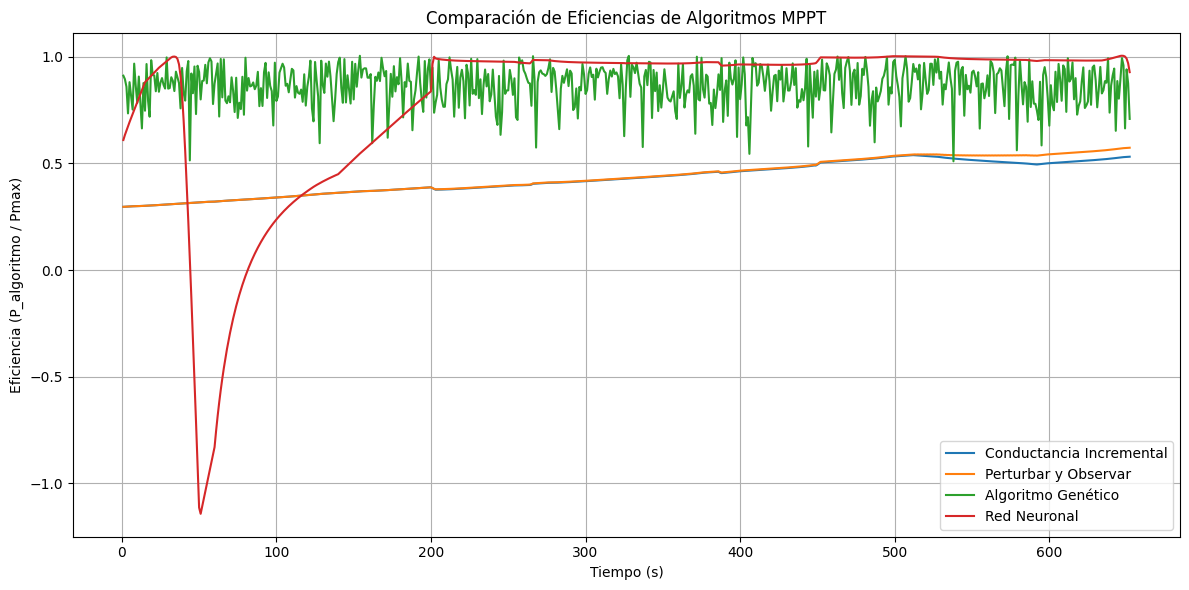

In [ ]:
# Parámetros adicionales para los algoritmos
delta_V = 0.01  # Paso de voltaje para P&O e IC
population_size = 10  # Para el algoritmo genético
generations = 5       # Para el algoritmo genético
V_min = 6
V_max = V_oc_ref * 1.2

# Entrenar la red neuronal antes del bucle principal
time_steps = np.arange(time_start, time_end + 1)
model_nn = train_neural_network(time_steps, V_oc_ref)

# Variables para almacenar los resultados
results = {
    'Tiempo': [],
    'Pmax': [],
    'P_IC': [],
    'P_PO': [],
    'P_GA': [],
    'P_NN': [],
    'Eficiencia_IC': [],
    'Eficiencia_PO': [],
    'Eficiencia_GA': [],
    'Eficiencia_NN': []
}

# Inicialización de variables para P&O e IC
V_prev_IC = V_min
V_prev_PO = V_min
I_prev_IC = current_single_diode(V_prev_IC, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
I_prev_PO = current_single_diode(V_prev_PO, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
P_prev_PO = V_prev_PO * I_prev_PO
direction_PO = 1  # Dirección inicial para P&O

# Bucle principal
for current_time in tqdm(time_steps, desc="Procesando tiempos"):
    # Actualizar V_max si V_oc cambia con el tiempo
    V_max_current = V_max  # Puedes ajustar esto si V_oc varía con el tiempo

    # Calcular Pmax real
    V_values = np.linspace(V_min, V_max_current, 100)
    P_values = []
    for V in V_values:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
        P = V * I if not np.isnan(I) else 0
        P_values.append(P)
    P_values = np.array(P_values)
    idx_max = np.argmax(P_values)
    P_max = P_values[idx_max]
    V_max_power = V_values[idx_max]

    # Conductancia Incremental
    I_current_IC = current_single_diode(V_prev_IC, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    dV_IC = delta_V
    dI_IC = I_current_IC - I_prev_IC
    V_next_IC = incremental_conductance(V_prev_IC, I_current_IC, dV_IC, dI_IC)
    I_prev_IC = I_current_IC
    V_prev_IC = V_next_IC
    P_IC = V_next_IC * I_current_IC

    # Perturbar y Observar
    V_next_PO, direction_PO = perturb_and_observe(V_prev_PO, P_prev_PO, delta_V, direction_PO)
    I_current_PO = current_single_diode(V_next_PO, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_current_PO = V_next_PO * I_current_PO
    if P_current_PO > P_prev_PO:
        # Continuar en la misma dirección
        pass
    else:
        # Cambiar de dirección
        direction_PO *= -1
    V_prev_PO = V_next_PO
    P_prev_PO = P_current_PO
    P_PO = P_current_PO

    # Algoritmo Genético
    V_GA = genetic_algorithm(current_time, V_min, V_max_current, population_size, generations)
    I_GA = current_single_diode(V_GA, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_GA = V_GA * I_GA if not np.isnan(I_GA) else 0

    # Red Neuronal
    V_NN = model_nn.predict([[current_time]])[0]
    I_NN = current_single_diode(V_NN, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_NN = V_NN * I_NN if not np.isnan(I_NN) else 0

    # Almacenar resultados
    results['Tiempo'].append(current_time)
    results['Pmax'].append(P_max)
    results['P_IC'].append(P_IC)
    results['P_PO'].append(P_PO)
    results['P_GA'].append(P_GA)
    results['P_NN'].append(P_NN)
    results['Eficiencia_IC'].append(P_IC / P_max if P_max != 0 else 0)
    results['Eficiencia_PO'].append(P_PO / P_max if P_max != 0 else 0)
    results['Eficiencia_GA'].append(P_GA / P_max if P_max != 0 else 0)
    results['Eficiencia_NN'].append(P_NN / P_max if P_max != 0 else 0)

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar los primeros resultados
print(df_results.head())

# Graficar las eficiencias
plt.figure(figsize=(12, 6))
plt.plot(df_results['Tiempo'], df_results['Eficiencia_IC'], label='Conductancia Incremental')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_GA'], label='Algoritmo Genético')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Eficiencia (P_algoritmo / Pmax)')
plt.title('Comparación de Eficiencias de Algoritmos MPPT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Experiment 2: Classical Algorithm vs Artificial Intelligence**
- **Objective**: Compare the classical **P&O** algorithm with the **Artificial Neural Network (ANN)** approach (MLP Regressor).
- **Metrics**:
  - Accuracy in predicting \(V_{\text{MPP}}\).
  - Adaptability to dynamic irradiance and temperature changes.
  - Energy harvesting efficiency over time.

#### **Experiment 3: Variations in GA Initialization and Selection**
- **Objective**: Explore how different initialization methods and selection strategies affect the performance of the Genetic Algorithm.
- **Aspects to analyze**:
  - Initialization types: Random vs. Uniform distributions.
  - Selection strategies: Tournament, Roulette Wheel, and Rank-Based.
- **Outcome**: Determine the most effective configurations for GA under different conditions.


#### **Experiment 4: Implementation of a Different Radiation Profile**
- **Objective**: Test the algorithms' adaptability and efficiency using a new irradiance profile.
- **Approach**:
  - Define a new time-based irradiance profile with dynamic variations.
  - Evaluate the algorithms' ability to track the MPP under these conditions.
